In [9]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Chemin du répertoire d'images
# source_dir = "Images"
# output_dir = "Dataset"

# # Ratios pour train, val et test
# train_ratio = 0.7
# val_ratio = 0.2
# test_ratio = 0.1

# # Vérification que les ratios forment un total de 1.0
# assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Les ratios doivent totaliser 1.0"

# # Création des répertoires de sortie
# for split in ['train', 'val', 'test']:
#     split_dir = os.path.join(output_dir, split)
#     os.makedirs(split_dir, exist_ok=True)

# # Parcourir chaque sous-dossier (classe/race)
# for breed in os.listdir(source_dir):
#     breed_path = os.path.join(source_dir, breed)
#     if not os.path.isdir(breed_path):
#         continue

#     # Liste des fichiers pour la classe
#     images = [os.path.join(breed_path, img) for img in os.listdir(breed_path)]
    
#     # Diviser les images en train, val et test
#     train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
#     val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

#     # Fonction pour copier les fichiers dans les répertoires appropriés
#     def copy_images(images, split):
#         split_dir = os.path.join(output_dir, split, breed)
#         os.makedirs(split_dir, exist_ok=True)
#         for img in images:
#             shutil.copy(img, split_dir)
    
#     # Copier les fichiers dans les dossiers train, val et test
#     copy_images(train_imgs, 'train')
#     copy_images(val_imgs, 'val')
#     copy_images(test_imgs, 'test')

# print("Les images ont été divisées en train, val et test.")

In [10]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import time

# Configuration des chemins des données
train_dir = "/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train"
val_dir = "/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val"
test_dir = "/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/test"

# Prétraitement des données
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Chargement du modèle VGG16 pré-entraîné
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajout d'une tête personnalisée
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model_vgg16= Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Compilation du modèle
model_vgg16.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle
EPOCHS = 10
start_time_fit = time.time() # en secondes
history = model_vgg16.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator)
time_fit = (time.time() - start_time_fit)

# Évaluation sur les données de test
test_loss, test_acc = model_vgg16.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Found 505 images belonging to 3 classes.
Found 144 images belonging to 3 classes.
Found 74 images belonging to 3 classes.


/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/envp6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4713 - loss: 3.1636 - val_accuracy: 0.6181 - val_loss: 1.5693
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6474 - loss: 1.0889 - val_accuracy: 0.7708 - val_loss: 0.4645
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7273 - loss: 0.6418 - val_accuracy: 0.8750 - val_loss: 0.3492
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7511 - loss: 0.6242 - val_accuracy: 0.8750 - val_loss: 0.3230
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7847 - loss: 0.5194 - val_accuracy: 0.8889 - val_loss: 0.3218
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8055 - loss: 0.5545 - val_accuracy: 0.9167 - val_loss: 0.2814
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8137 - loss: 0.4637 - val_accuracy: 0.9167 - val_loss: 0.2393
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8056 - loss: 0.4788 - val_accuracy: 0.9236 - val_loss:

In [11]:
# (Facultatif) Débloquer les couches pour un fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model_vgg16.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time_fit = time.time() # en secondes
history_finetune = model_vgg16.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)
time_fit = (time.time() - start_time_fit)

# Évaluation finale
start_time_test = time.time() # en secondes
test_loss, test_acc = model_vgg16.evaluate(test_generator)
time_test = (time.time() - start_time_test)

print(f"Fine-tuned Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7277 - loss: 0.8901 - val_accuracy: 0.9306 - val_loss: 0.2610
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9023 - loss: 0.2979 - val_accuracy: 0.9653 - val_loss: 0.1424
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9247 - loss: 0.2078 - val_accuracy: 0.9444 - val_loss: 0.1622
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9290 - loss: 0.1889 - val_accuracy: 0.9583 - val_loss: 0.1567
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9754 - loss: 0.0826 - val_accuracy: 0.9653 - val_loss: 0.1916
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9674 - loss: 0.1085 - val_accuracy: 0.9583 - val_loss: 0.1889
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9558 - loss: 0.1046 - val_accuracy: 0.9444 - val_loss: 0.2048
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9554 - loss: 0.1029 - val_accuracy: 0.9653 - val_loss:

In [12]:

# Évaluation finale
start_time_test = time.time() # en secondes
test_loss, test_acc = model_vgg16.evaluate(test_generator)
time_test = (time.time() - start_time_test)

print(f"Fine-tuned Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8913 - loss: 0.4399
Fine-tuned Test Accuracy: 89.19%


In [13]:
print("Temps d'entraînement:", time_fit)
print("Temps de test:", time_test)

Temps d'entraînement: 468.52051615715027
Temps de test: 4.447451829910278


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

# Exemple de courbes de perte et d'exactitude
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 4))
    
    # Courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Courbe de perte')
    
    # Courbe d'exactitude
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Courbe d\'exactitude')
    
    plt.show()

# Exemple de matrice de confusion
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de confusion')
    plt.show()

# Exemple de courbes ROC et AUC
def plot_roc_auc(y_true, y_scores, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbes ROC multi-classes')
    plt.legend(loc='best')
    plt.show()

# Utilisation des fonctions
# history = model.fit(...)  # Historique de l'entraînement
plot_loss_accuracy(history_finetune)

# y_true = ...  # Vraies étiquettes
# y_pred = ...  # Prédictions du modèle
# class_names = [...]  # Noms des classes
#plot_confusion_matrix(y_true, predictions, class_names)

# y_scores = ...  # Scores de prédiction du modèle
# n_classes = len(class_names)
# plot_roc_auc(y_true, y_scores, n_classes)

<Figure size 1200x400 with 2 Axes>

In [19]:
# Sauvegarder le modèle dans un fichier .h5
model_vgg16.save('dog_breed_vgg16_p7.h5')

## YOLO

In [15]:
from ultralytics import YOLO

# Charger un modèle pré-entraîné YOLOv11 pour la classification
model_yolo = YOLO('yolo11n-cls.pt')

# Commencer l'entraînement avec votre dataset
model_yolo.train(data='/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset', epochs=10, imgsz=224)

Ultralytics 8.3.52 🚀 Python-3.9.6 torch-2.5.1 CPU (Apple M1 Pro)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train116, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train... 505 images, 0 corrupt: 100%|██████████| 505/505 [00:00<?, ?it/s]
val: Scanning /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val... 144 images, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to /Users/randaalsabbagh/runs/classify/train116
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size



      10/10         0G    0.05641          9        224: 100%|██████████| 32/32 [00:16<00:00,  2.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all      0.951          1

10 epochs completed in 0.073 hours.


Optimizer stripped from /Users/randaalsabbagh/runs/classify/train116/weights/last.pt, 3.2MB
Optimizer stripped from /Users/randaalsabbagh/runs/classify/train116/weights/best.pt, 3.2MB

Validating /Users/randaalsabbagh/runs/classify/train116/weights/best.pt...
Ultralytics 8.3.52 🚀 Python-3.9.6 torch-2.5.1 CPU (Apple M1 Pro)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train... found 505 images in 3 classes ✅ 
val: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val... found 144 images in 3 classes ✅ 
test: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/test... found 74 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


                   all      0.993          1
Speed: 0.0ms preprocess, 14.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /Users/randaalsabbagh/runs/classify/train116


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x33271ba60>
curves: []
curves_results: []
fitness: 0.9965277910232544
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9930555820465088, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9965277910232544}
save_dir: PosixPath('/Users/randaalsabbagh/runs/classify/train116')
speed: {'preprocess': 0.00039074156019422744, 'inference': 14.39822879102495, 'loss': 3.476937611897787e-05, 'postprocess': 6.953875223795573e-05}
task: 'classify'
top1: 0.9930555820465088
top5: 1.0

Inference

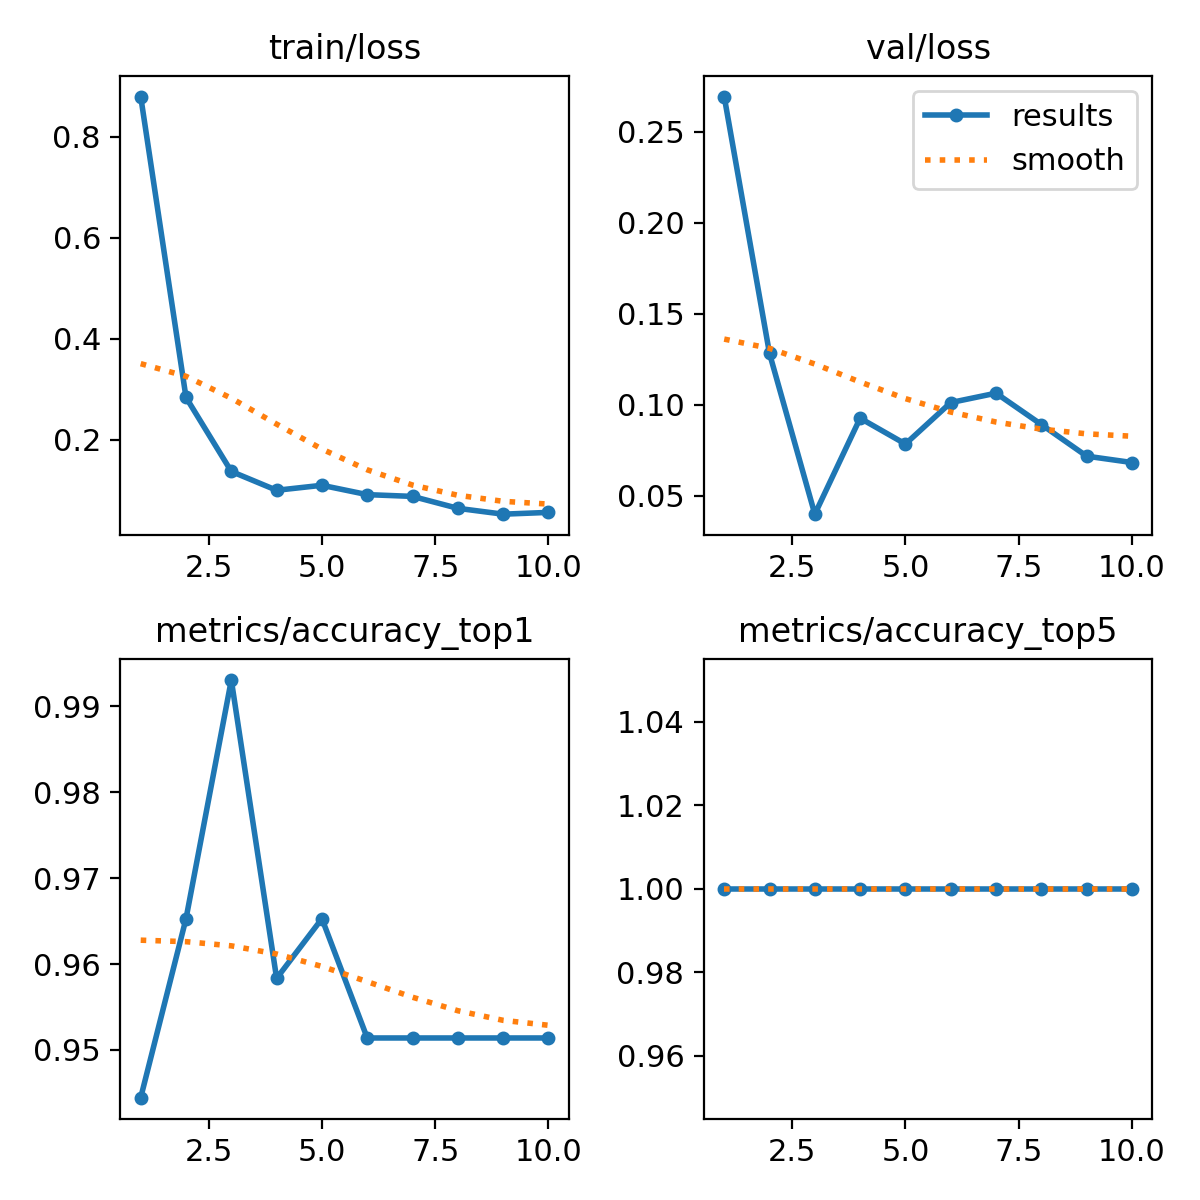

In [16]:
from IPython.display import Image
Image("/Users/randaalsabbagh/runs/classify/train106/results.png", width=600)

In [17]:
metrics = model_yolo.val()  # no arguments needed
# You can take a look at certain stats like the following
metrics.top1  
metrics.top5  

Ultralytics 8.3.52 🚀 Python-3.9.6 torch-2.5.1 CPU (Apple M1 Pro)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/train... found 505 images in 3 classes ✅ 
val: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val... found 144 images in 3 classes ✅ 
test: /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/test... found 74 images in 3 classes ✅ 


val: Scanning /Users/randaalsabbagh/Desktop/MACHINE_LEARNING/P6/Dataset/val... 144 images, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


                   all      0.993          1
Speed: 0.0ms preprocess, 16.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /Users/randaalsabbagh/runs/classify/train1162


1.0

In [18]:
model_yolo.save("modelyolo.pt")